### Imports

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import sys
import os
import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
import xgboost as xgb
from collections import Counter
import codecs, json

In [4]:
data_meteo = pd.read_table("data_meteo.csv", sep=',', index_col=0)
data_meteo.index=pd.to_datetime((data_meteo.index), format="%Y/%m/%d")
data_meteo

,Название метеостанции,Максимальная скорость,Средняя скорость ветра,Направление ветра,Температура воздуха по сухому терм-ру,Атмосферное давление на уровне станции,Атмосферное давление на уровне моря,Сумма осадков,Температура поверхности почвы,Парциальное давление водяного пара,Относительная влажность воздуха,Температура точки росы
Дата,,,,,,,,,,,,
1965-12-31,Барабинск,NaN,2.0,160.0,-11.2,1006.4,1022.4,NaN,-11.0,NaN,88.0,-12.0
1965-12-31,Барабинск,NaN,2.0,160.0,-10.5,1005.9,1021.8,NaN,-10.0,NaN,88.0,-11.0
1965-12-31,Барабинск,NaN,3.0,160.0,-10.7,1005.6,1021.6,NaN,-10.0,NaN,88.0,-12.0
1966-01-01,Барабинск,NaN,3.0,140.0,-10.9,1003.3,1019.2,0.2,-12.0,NaN,88.0,-12.0
1966-01-01,Барабинск,NaN,1.0,160.0,-11.4,1002.3,1018.2,NaN,-12.0,NaN,90.0,-12.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30,Яйлю,5.0,0.0,0.0,10.4,959.4,1016.2,0.0,13.1,12.2,96.0,9.8
2021-06-30,Яйлю,2.0,1.0,158.0,15.3,959.6,1015.3,0.0,27.2,13.9,80.0,11.9
2021-06-30,Яйлю,2.0,1.0,152.0,18.6,958.2,1013.3,0.0,31.5,12.9,60.0,10.9


### Functions to compare

In [5]:
# Previous function
def make_ds_add_old(Data, start, end, from_horizon=15, to_horizon=30, delta_in_x=30, station='Барабинск', added_feature=['Температура воздуха по сухому термометру']):
  '''
  Makes a dataset consisting of X and y for a special meteostation.

  start - start date of the period, for example pd.to_datetime('1990-01-01');
  end - end date of the period, for example pd.to_datetime('1993-01-31'), dataset will be gathered to 1993-01-01;
  to_horizon - how many days we look ahead in search of wind speed exceeds;
  delta_in_x - how many days are included into X, always less than delta_horizon.
  '''
  X, y = [], []
  # added_feature = ['Дата', 'Максимальная скорость', 'Средняя скорость ветра'] + added_feature
  added_feature = ['Максимальная скорость', 'Средняя скорость ветра'] + added_feature
  station = Data.loc[Data['Название метеостанции'] == station][added_feature]
  station_train = station.loc[(station.index >= start) & (station.index <= end+datetime.timedelta(to_horizon))]
  # added_feature.remove('Дата')
  station_train = station_train.groupby(station_train.index).max()[added_feature]
  for index, row in station_train.iterrows():
    da = index
    if da == end + datetime.timedelta(1):
      break
    st = station_train.loc[(station_train.index>da+datetime.timedelta(from_horizon)) & (station_train.index <= da+datetime.timedelta(to_horizon))] # Сколько дней смотрим вперед
    if np.max(st['Максимальная скорость']) >= 20:
      y.append(1)
    else:
      y.append(0) 
    st_x = station_train.loc[(station_train.index>=da) & (station_train.index < da+datetime.timedelta(delta_in_x))] # Сколько дней включаем в Х

    X.append(np.array(st_x).reshape(-1))
    # X.append(np.array(st_x[added_feature]).reshape(-1))

  X = np.array(X)
  return X, y

def metrics(model, X_test, y_test):
  y_pred = model.predict(X_test)
  r_a_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
  acc = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  metrics = [r_a_score, acc, precision, recall, f1]
  return metrics

In [6]:
# New function
def make_ds_add_feat(Data, start, end, from_horizon=15, to_horizon=30, delta_in_x=30, station='Барабинск', added_feature=['Температура воздуха по сухому термометру']):
  '''
  Makes a dataset consisting of X and y for a special meteostation.

  start - start date of the period, for example pd.to_datetime('1990-01-01');
  end - end date of the period, for example pd.to_datetime('1993-01-31'), dataset will be gathered to 1993-01-01;
  to_horizon - how many days we look ahead in search of wind speed exceeds;
  delta_in_x - how many days are included into X, always less than delta_horizon;
  it's the first commit, finish it later.
  '''
  X, y = [], []
  added_feature = ['Максимальная скорость', 'Средняя скорость ветра'] + added_feature
  station = Data.loc[Data['Название метеостанции'] == station][added_feature]
  station_train = station.loc[(station.index >= start) & (station.index <= end+datetime.timedelta(to_horizon))]
  # station_train = station_train.groupby(['Дата']).max()
  station_train = station_train.groupby(station_train.index).max()
  y_ind = np.where(station_train.rolling(window='10D')['Максимальная скорость'].max()>=20)[0] - (to_horizon)  # change from_horizon on new variable
  y = np.array([0]*(station_train.shape[0] - to_horizon))
  y_ind = [x for x in y_ind if x > 0]
  y[y_ind] = 1
  lis = [station_train.iloc[i:i+delta_in_x] for i in range(station_train.shape[0] - to_horizon)]
  X = np.array(lis).reshape(np.array(lis).shape[0], -1)

  return X, y

### Comparison

In [7]:
begin_of_ds_train = pd.to_datetime('1990-01-01')
end_of_ds_train = pd.to_datetime('1992-12-31')
begin_of_ds_test = pd.to_datetime('1993-01-01')
end_of_ds_test = pd.to_datetime('1995-12-31')
X_train, y_train = make_ds_add_old(data_meteo, begin_of_ds_train, end_of_ds_train, from_horizon=20, to_horizon=30, delta_in_x=15, station='Бийск-Зональная', added_feature=[])
X_test, y_test = make_ds_add_old(data_meteo, begin_of_ds_test, end_of_ds_test, from_horizon=20, to_horizon=30, delta_in_x=15, station='Бийск-Зональная', added_feature=[])

In [8]:
X_train_new, y_train_new = make_ds_add_feat(data_meteo, begin_of_ds_train, end_of_ds_train, from_horizon=20, to_horizon=30, delta_in_x=15, station='Бийск-Зональная', added_feature=[])
X_test_new, y_test_new = make_ds_add_feat(data_meteo, begin_of_ds_test, end_of_ds_test, from_horizon=20, to_horizon=30, delta_in_x=15, station='Бийск-Зональная', added_feature=[])

In [9]:
(X_test == X_test_new).all()

True

In [10]:
(y_train == y_train_new).all()

True

### Model on gathered datasets

In [135]:
clf_xgb = xgb.XGBClassifier(n_jobs=-1, random_state=1, reg_lambda=0, reg_alpha=10)
clf_xgb.fit(X_train_new, y_train_new)
metrics(clf_xgb, X_test_new, y_test_new)

[0.4966986146639647, 0.8867579908675799, 0.0, 0.0, 0.0]

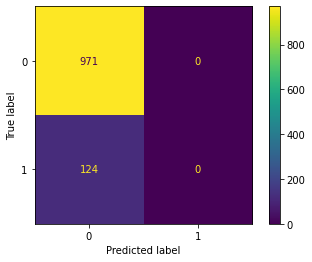

In [136]:
y_pred = clf_xgb.predict(X_test_new)
cm = confusion_matrix(y_test_new, y_pred, labels=clf_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_xgb.classes_)
disp.plot();

Poor performance, as there are no enough exceedance of 20 m/s (only 16 for 3 years).

In [155]:
a = data_meteo.loc[data_meteo['Название метеостанции'] == 'Бийск-Зональная'][['Максимальная скорость', 'Средняя скорость ветра']]
a = a.loc[(a.index>=begin_of_ds_test) & (a.index <= end_of_ds_test+datetime.timedelta(30))]
ag = a.groupby(a.index).max()
ag

,Максимальная скорость,Средняя скорость ветра
Дата,,
1993-01-01,5.0,2.0
1993-01-02,3.0,1.0
1993-01-03,3.0,2.0
1993-01-04,4.0,2.0
1993-01-05,11.0,7.0
...,...,...
1996-01-26,13.0,8.0
1996-01-27,7.0,3.0
1996-01-28,3.0,2.0


In [157]:
(ag['Максимальная скорость'] >= 20).sum()

16

Try different time periods